# Libraries and Imports


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# check for gpu
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data and Preprocessing


In [36]:
data_dir = "data"
batch_size = 64
img_height, img_width = 196, 196

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    validation_split=0.3,
    # rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # fill_mode="nearest",
    )

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    class_mode="sparse",
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    class_mode="sparse",
)

Found 259 images belonging to 10 classes.


Found 107 images belonging to 10 classes.


# Model and Training


In [43]:
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# load pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(196, 196, 3))

# freeze the weights of the pre-trained layers
base_model.trainable = False

# custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks = [scheduler, early_stopping]

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_generator, validation_data=validation_generator, epochs=80, callbacks=callbacks)


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 98, 98, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 98, 98, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 98, 98, 32)        128

# Evaluate


2/2 [==============================] - 0s 138ms/step - loss: 1.1093 - accuracy: 0.6168
Test Loss: 1.109275221824646
Test Accuracy: 0.6168224215507507


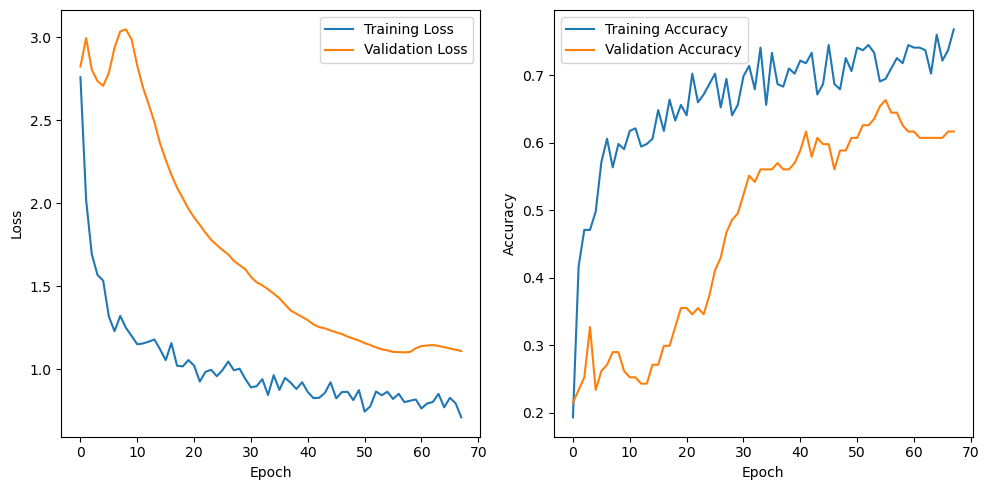

In [45]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

In [ ]:
# 